****** MODELO DE PREDICCION DE PRECIOS DE VIVIENDA USADA EN BOGOTA CON BASE EN DATOS PUBLICOS ******

Este caso de uso permite ver como el uso de datos publicos es eficiente para recursos de uso general y asi generar confianza en su uso y aplicacion tanto en entornos gubernamentales como en entornos privados 

vamos a clonar el repositorio donde se encuentran almacenados los datos que han sido descargados desde los sitios web oficiales de portales del gobierno colombiano relacionados con el sector inmobiliario especificamente en el sector de vivienda usada.

In [195]:
# conexion y clonacion del repositorio publico donde se encuentra almacenada la documentacion y los data sets 
!git clone https://github.com/andres-fuentex/tfm-avm-bogota.git
%cd tfm-avm-bogota
!git lfs install
!git lfs pull


fatal: destination path 'tfm-avm-bogota' already exists and is not an empty directory.
/kaggle/working/tfm-avm-bogota/tfm-avm-bogota
Updated git hooks.
Git LFS initialized.


In [196]:
%cd /kaggle/working/tfm-avm-bogota
!git pull origin main
!git lfs pull

/kaggle/working/tfm-avm-bogota
From https://github.com/andres-fuentex/tfm-avm-bogota
 * branch            main       -> FETCH_HEAD
Already up to date.


In [197]:
# verificacion de los archivos para poder trabajar 
from pathlib import Path
datos_brutos = Path('/kaggle/working/tfm-avm-bogota/datos_brutos') # ubicacion de los archivos 
print("Archivos en datos_brutos:") # buscamos que muestre los archivos que estan en esa ubicacion
for f in datos_brutos.iterdir():
    print(" •", f.name, round(f.stat().st_size/1_048_576, 2), "MB") # para que muestre el tamaño de cada archivo

Archivos en datos_brutos:
 • area_actividad_pot.zip 1.84 MB
 • tm_estaciones.geojson 0.03 MB
 • delitos_alto_impacto.zip 0.62 MB
 • valor_m2_manzana.zip 12.92 MB
 • estratificacion_manzana.zip 20.31 MB
 • colegios_bogota.xlsx 1.12 MB
 • ipvu_banco_republica.xlsx 0.01 MB


In [198]:
# instalacion de librerias necesarias para el proyecto 
!pip install geopandas shapely fiona pyogrio

In [199]:
import pandas as pd, geopandas as gpd

RUTA = Path('/kaggle/working/tfm-avm-bogota/datos_brutos')

""" en los casos que fue necesario descargar el shape usamos geopandas para abrir los zip y geo json y pandas para abrir los cvs y excel """
# se asignan variables a cada data set para que se traten de la misma forma integrando diferentes fuentes de datos en diferentes formatos 
valor_m2   = gpd.read_file(RUTA/'valor_m2_manzana.zip')
estrato    = gpd.read_file(RUTA/'estratificacion_manzana.zip')
delitos    = gpd.read_file(RUTA/'delitos_alto_impacto.zip')
transporte = gpd.read_file(RUTA/'tm_estaciones.geojson')
colegios   = pd.read_excel(RUTA/'colegios_bogota.xlsx',
                            header=11)
area_pot   = gpd.read_file(RUTA/'area_actividad_pot.zip')
ipvu       = pd.read_excel(RUTA/'ipvu_banco_republica.xlsx',
                           sheet_name='Datos')

print("Registros cargados:")
print("valor_m2:", len(valor_m2))
print("estrato :", len(estrato))
print("delitos :", len(delitos))
print("transporte:",len(transporte))
print("colegios:", len(colegios))
print("area_pot:", len(area_pot))
print("ipvu    :", ipvu.shape)


Registros cargados:
valor_m2: 14755
estrato : 43765
delitos : 21
transporte: 140
colegios: 2227
area_pot: 1141
ipvu    : (152, 3)


** realizamos analisis exploratorio de cada uno de los data set para aplicar a la metodologia crisp dm el entendimiento de los datos 

data set de valor_m2

In [200]:
valor_m2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14755 entries, 0 to 14754
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Manzana_Id  14755 non-null  object  
 1   VrInt_Resi  14755 non-null  float64 
 2   VrInt_Com_  14755 non-null  float64 
 3   VrInt_Depo  14755 non-null  float64 
 4   VrInt_Indu  14755 non-null  float64 
 5   VrInt_Dota  14755 non-null  float64 
 6   VrInt_Bode  14755 non-null  float64 
 7   Vigencia    14755 non-null  object  
 8   Area_m2     14755 non-null  float64 
 9   geometry    14755 non-null  geometry
dtypes: float64(7), geometry(1), object(2)
memory usage: 1.1+ MB


In [201]:
valor_m2.head(2)

,Manzana_Id,VrInt_Resi,VrInt_Com_,VrInt_Depo,VrInt_Indu,VrInt_Dota,VrInt_Bode,Vigencia,Area_m2,geometry
0,006107004,0.00,4489412.84,0.0,0.0,0.0,4275881.56,2024-01-01,17488.405077,"POLYGON ((-74.08570 4.61221, -74.08562 4.61214..."
1,004503014,1221846.15,0.00,0.0,0.0,0.0,2900644.13,2024-01-01,12985.146073,"POLYGON ((-74.13185 4.61534, -74.13191 4.61531..."


cuenta con variables clave como el id de la manzana, cuenta con valores por el uso del suelo por ejemplo si es residencial, si es comercial, si es deportivo, industrial, de dotacion o de bodegague una fecha el area que compone esa manzana y las coordenadas de la manzana.

Se manejara la regla y se sostiene porque el valor que buscamos es residencial que corresponde a vivienda pero si llegado al caso que no sea de ese tipo usaremos el promedio de los otros valores para tener un estimador esto teniendo en cuenta la renovación urbana actual de la ciudad

In [202]:
# calculo valor_m2_media con la regla híbrida
usos = ['VrInt_Resi', 'VrInt_Com_', 'VrInt_Depo',
        'VrInt_Indu', 'VrInt_Dota', 'VrInt_Bode']

def regla_hibrida(row):
    if row['VrInt_Resi'] > 0:
        return row['VrInt_Resi']
    otros_val = [row[u] for u in usos[1:] if row[u] > 0]
    return sum(otros_val)/len(otros_val) if otros_val else None

valor_m2['valor_m2_media'] = valor_m2.apply(regla_hibrida, axis=1)
valor_m2 = valor_m2.dropna(subset=['valor_m2_media'])
print("Manzanas válidas:", len(valor_m2))


Manzanas válidas: 14755


se mantuvieron validas todas las manzanas por tano no afecta el data set la aplicacion de la regla de estimacion de precio por metro cuadrado

<Axes: >

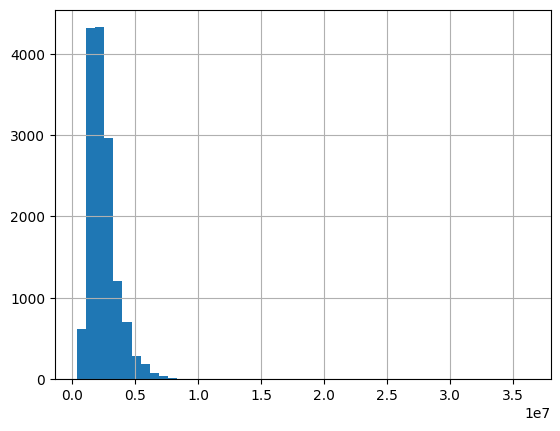

In [203]:
# miramos una distribucion de los datos con un histograma 
valor_m2['valor_m2_media'].hist(bins=50)


In [204]:
valor_m2.head(2)

,Manzana_Id,VrInt_Resi,VrInt_Com_,VrInt_Depo,VrInt_Indu,VrInt_Dota,VrInt_Bode,Vigencia,Area_m2,geometry,valor_m2_media
0,006107004,0.00,4489412.84,0.0,0.0,0.0,4275881.56,2024-01-01,17488.405077,"POLYGON ((-74.08570 4.61221, -74.08562 4.61214...",4382647.20
1,004503014,1221846.15,0.00,0.0,0.0,0.0,2900644.13,2024-01-01,12985.146073,"POLYGON ((-74.13185 4.61534, -74.13191 4.61531...",1221846.15


** data set estratificacion de manzanas en bogota **

In [205]:
estrato.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43765 entries, 0 to 43764
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    43765 non-null  int64   
 1   CODIGO_MAN  43765 non-null  object  
 2   ESTRATO     43765 non-null  int64   
 3   CODIGO_ZON  43765 non-null  int64   
 4   CODIGO_CRI  0 non-null      object  
 5   NORMATIVA   43765 non-null  object  
 6   ACTO_ADMIN  43765 non-null  object  
 7   NUMERO_ACT  43765 non-null  int64   
 8   FECHA_ACTO  43765 non-null  object  
 9   ESCALA_CAP  0 non-null      object  
 10  FECHA_CAPT  43765 non-null  object  
 11  RESPONSABL  43765 non-null  object  
 12  SHAPE_AREA  43765 non-null  float64 
 13  SHAPE_LEN   43765 non-null  float64 
 14  geometry    43765 non-null  geometry
dtypes: float64(2), geometry(1), int64(4), object(8)
memory usage: 5.0+ MB


In [206]:
valor_m2['valor_m2_media'].round().astype(int).describe()

count    1.475500e+04
mean     2.455486e+06
std      1.249070e+06
min      3.987740e+05
25%      1.656994e+06
50%      2.243201e+06
75%      2.953031e+06
max      3.620822e+07
Name: valor_m2_media, dtype: float64

** eda dataset 2 estrato 

In [207]:
estrato.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43765 entries, 0 to 43764
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    43765 non-null  int64   
 1   CODIGO_MAN  43765 non-null  object  
 2   ESTRATO     43765 non-null  int64   
 3   CODIGO_ZON  43765 non-null  int64   
 4   CODIGO_CRI  0 non-null      object  
 5   NORMATIVA   43765 non-null  object  
 6   ACTO_ADMIN  43765 non-null  object  
 7   NUMERO_ACT  43765 non-null  int64   
 8   FECHA_ACTO  43765 non-null  object  
 9   ESCALA_CAP  0 non-null      object  
 10  FECHA_CAPT  43765 non-null  object  
 11  RESPONSABL  43765 non-null  object  
 12  SHAPE_AREA  43765 non-null  float64 
 13  SHAPE_LEN   43765 non-null  float64 
 14  geometry    43765 non-null  geometry
dtypes: float64(2), geometry(1), int64(4), object(8)
memory usage: 5.0+ MB


se identifican variables claves el campo codigo_man permite unir con el data set 1 codigo Manzana_id y alli tendriamos valor metro cuadrado y estrato que son factores importantes en la prediccion del precio codigo zona podria estar relacionado con la localidad que tambien es importante en caso dado podria servir los shape y el geometry que posiblemente este alineado con el data set 1.

los otros campos son informacion adicional que podria no aportar a este trabajo 

In [208]:
estrato.head(2)

,OBJECTID,CODIGO_MAN,ESTRATO,CODIGO_ZON,CODIGO_CRI,NORMATIVA,ACTO_ADMIN,NUMERO_ACT,FECHA_ACTO,ESCALA_CAP,FECHA_CAPT,RESPONSABL,SHAPE_AREA,SHAPE_LEN,geometry
0,695738,00820516,5,15,None,DEC551,DEC,551,2019-09-12,None,2019-09-12,560,21725.000837,676.305821,"POLYGON ((-74.05448 4.64394, -74.05449 4.64392..."
1,695739,00460146,2,5,None,DEC551,DEC,551,2019-09-12,None,2019-09-12,560,1440.019910,183.987736,"POLYGON ((-74.16792 4.64359, -74.16794 4.64361..."


In [209]:
print("Ejemplos de valor_m2['Manzana_Id']:", valor_m2['Manzana_Id'].astype(str).unique()[:5])
print("Ejemplos de estrato['CODIGO_MAN']  :", estrato['CODIGO_MAN'].astype(str).unique()[:5])


Ejemplos de valor_m2['Manzana_Id']: ['006107004' '004503014' '007309002' '002311003' '003101021']
Ejemplos de estrato['CODIGO_MAN']  : ['00820516' '00460146' '00460145' '00454106' '00650102']


el codigo_man parece faltarle un numero para coincidir con el otro 

In [210]:
ids_valor_m2 = set(valor_m2['Manzana_Id'].astype(str))
ids_estrato  = set(estrato['CODIGO_MAN'].astype(str))

coincidencias = ids_valor_m2 & ids_estrato
print(f"Número de coincidencias: {len(coincidencias)}")


Número de coincidencias: 0


In [211]:
valor_m2['id_manzana'] = valor_m2['Manzana_Id'].astype(str).str[-8:]
estrato['id_manzana']  = estrato['CODIGO_MAN'].astype(str).str.zfill(8)


In [212]:
import geopandas as gpd
from geopandas.tools import sjoin

# Proyectar ambos al mismo CRS métrico (Bogotá usa MAGNA-SIRGAS / EPSG:3116)
valor_m2_proj = valor_m2.to_crs(epsg=3116)
estrato_proj  = estrato.to_crs(epsg=3116)

# Realizar join espacial: buscamos manzanas de estrato que contienen manzanas de valor_m2
df_join = gpd.sjoin(valor_m2_proj, estrato_proj[['ESTRATO','CODIGO_ZON', 'geometry']], 
                    how='left', predicate='intersects')

# Mostrar resumen
print(f"Registros con estrato asignado: {df_join['ESTRATO'].notna().sum()} de {len(df_join)}")


Registros con estrato asignado: 17939 de 17940


In [213]:
df_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 17940 entries, 0 to 14754
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Manzana_Id      17940 non-null  object  
 1   VrInt_Resi      17940 non-null  float64 
 2   VrInt_Com_      17940 non-null  float64 
 3   VrInt_Depo      17940 non-null  float64 
 4   VrInt_Indu      17940 non-null  float64 
 5   VrInt_Dota      17940 non-null  float64 
 6   VrInt_Bode      17940 non-null  float64 
 7   Vigencia        17940 non-null  object  
 8   Area_m2         17940 non-null  float64 
 9   geometry        17940 non-null  geometry
 10  valor_m2_media  17940 non-null  float64 
 11  id_manzana      17940 non-null  object  
 12  index_right     17939 non-null  float64 
 13  ESTRATO         17939 non-null  float64 
 14  CODIGO_ZON      17939 non-null  float64 
dtypes: float64(11), geometry(1), object(3)
memory usage: 2.2+ MB


In [214]:
df_join.head(2)

,Manzana_Id,VrInt_Resi,VrInt_Com_,VrInt_Depo,VrInt_Indu,VrInt_Dota,VrInt_Bode,Vigencia,Area_m2,geometry,valor_m2_media,id_manzana,index_right,ESTRATO,CODIGO_ZON
0,006107004,0.00,4489412.84,0.0,0.0,0.0,4275881.56,2024-01-01,17488.405077,"POLYGON ((999091.262 1001769.953, 999099.470 1...",4382647.20,06107004,12850.0,0.0,11.0
1,004503014,1221846.15,0.00,0.0,0.0,0.0,2900644.13,2024-01-01,12985.146073,"POLYGON ((993970.475 1002117.145, 993962.939 1...",1221846.15,04503014,14440.0,3.0,9.0


In [215]:
# Eliminamos el registro que no tiene estrato (y tampoco CODIGO_ZON)
df_join = df_join.dropna(subset=['ESTRATO'])

# Verificamos que ahora estén solo los registros emparejados
print(f"Registros finales luego de limpieza: {len(df_join)}")


Registros finales luego de limpieza: 17939


** eda data set 3

In [216]:
delitos.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Columns: 116 entries, CMIULOCAL to geometry
dtypes: float64(112), geometry(1), object(3)
memory usage: 19.2+ KB


In [217]:
delitos.head(22)

,CMIULOCAL,CMNOMLOCAL,CMMES,CMH18CONT,CMH19CONT,CMH20CONT,CMHVAR,CMHTOTAL,CMLP18CONT,CMLP19CONT,CMLP20CONT,CMLPVAR,CMLPTOTAL,CMHP18CONT,CMHP19CONT,CMHP20CONT,CMHPVAR,CMHPTOTAL,CMHR18CONT,CMHR19CONT,CMHR20CONT,CMHRVAR,CMHRTOTAL,CMHA18CONT,CMHA19CONT,CMHA20CONT,CMHAVAR,CMHATOTAL,CMHB18CONT,CMHB19CONT,CMHB20CONT,CMHBVAR,CMHBTOTAL,CMHC18CONT,CMHC19CONT,CMHC20CONT,CMHCVAR,CMHCTOTAL,CMHCE18CON,CMHCE19CON,CMHCE20CON,CMHCEVAR,CMHCETOTAL,CMHM18CONT,CMHM19CONT,CMHM20CONT,CMHMVAR,CMHMTOTAL,CMDS18CONT,CMDS19CONT,CMDS20CONT,CMDSVAR,CMDSTOTAL,CMVI18CONT,CMVI19CONT,CMVI20CONT,CMVIVAR,CMVITOTAL,CMH21CONT,CMLP21CONT,CMHP21CONT,CMHR21CONT,CMHA21CONT,CMHB21CONT,CMHCE21CON,CMHM21CONT,CMHC21CONT,CMDS21CONT,CMVI21CONT,CMH22CONT,CMLP22CONT,CMHP22CONT,CMHA22CONT,CMHB22CONT,CMHCE22CON,CMHM22CONT,CMHC22CONT,CMDS22CONT,CMVI22CONT,CMHR22CONT,CMH23CONT,CMLP23CONT,CMHP23CONT,CMHR23CONT,CMHA23CONT,CMHB23CONT,CMHCE23CON,CMHM23CONT,CMHC23CONT,CMDS23CONT,CMVI23CONT,CMH24CONT,CMLP24CONT,CMHP24CONT,CMHR24CONT,CMHA24CONT,CMHB24CONT,CMHCE24CON,CMHM24CONT,CMHC24CONT,CMDS24CONT,CMVI24CONT,CMH25CONT,CMLP25CONT,CMHP25CONT,CMHR25CONT,CMHA25CONT,CMHB25CONT,CMHCE25CON,CMHM25CONT,CMHC25CONT,CMDS25CONT,CMVI25CONT,SHAPE_AREA,SHAPE_LEN,geometry
0,09,Fontibón,Ene-Abr (2024vs2025),4.0,7.0,4.0,85.71,378.0,398.0,309.0,158.0,80.82,6169.0,1871.0,2401.0,1851.0,-10.69,43138.0,135.0,162.0,130.0,-11.57,2003.0,49.0,48.0,39.0,80.56,954.0,149.0,219.0,176.0,-25.00,1814.0,423.0,436.0,284.0,-56.03,1931.0,1175.0,1363.0,982.0,0.0,10123.0,66.0,50.0,52.0,207.69,1341.0,65.0,70.0,57.0,32.53,2749.0,402.0,473.0,432.0,1.51,15766.0,6.0,266.0,1906.0,129.0,32.0,208.0,1074.0,33.0,229.0,60.0,396.0,7.0,385.0,2695.0,51.0,263.0,1362.0,56.0,319.0,98.0,609.0,117.0,12.0,214.0,2868.0,130.0,48.0,217.0,1221.0,66.0,369.0,61.0,225.0,7.0,146.0,2844.0,121.0,36.0,224.0,0.0,26.0,232.0,83.0,863.0,13.0,264.0,2540.0,107.0,65.0,168.0,607.0,80.0,102.0,110.0,876.0,0.002710,0.321915,"POLYGON ((-74.15857 4.66274, -74.15848 4.66279..."
1,19,Ciudad Bolívar,Ene-Abr (2024vs2025),83.0,57.0,61.0,61.82,378.0,808.0,781.0,576.0,-17.09,6169.0,954.0,1310.0,1127.0,-5.32,43138.0,182.0,183.0,128.0,-30.16,2003.0,55.0,61.0,59.0,-62.35,954.0,48.0,63.0,68.0,-57.32,1814.0,179.0,179.0,145.0,-76.79,1931.0,698.0,713.0,637.0,0.0,10123.0,146.0,116.0,92.0,-57.09,1341.0,157.0,177.0,200.0,38.16,2749.0,1502.0,998.0,1470.0,27.49,15766.0,59.0,678.0,1465.0,130.0,78.0,86.0,961.0,153.0,124.0,212.0,996.0,53.0,772.0,1615.0,83.0,84.0,837.0,228.0,139.0,287.0,1644.0,119.0,69.0,739.0,2123.0,121.0,159.0,104.0,758.0,246.0,180.0,337.0,2011.0,55.0,708.0,1785.0,126.0,162.0,82.0,0.0,268.0,168.0,207.0,1095.0,89.0,587.0,1690.0,88.0,61.0,35.0,358.0,115.0,39.0,286.0,1396.0,0.010585,0.702136,"POLYGON ((-74.21092 4.38691, -74.21114 4.38750..."
2,02,Chapinero,Ene-Abr (2024vs2025),5.0,3.0,1.0,-50.00,378.0,323.0,202.0,155.0,23.97,6169.0,3065.0,4111.0,2565.0,-33.97,43138.0,163.0,151.0,121.0,16.09,2003.0,15.0,14.0,21.0,-55.17,954.0,176.0,167.0,135.0,-32.67,1814.0,503.0,580.0,441.0,-60.96,1931.0,1926.0,2119.0,1521.0,0.0,10123.0,13.0,12.0,9.0,-27.78,1341.0,53.0,50.0,32.0,-40.31,2749.0,200.0,150.0,178.0,-19.15,15766.0,1.0,160.0,1821.0,83.0,7.0,108.0,1043.0,12.0,256.0,47.0,208.0,2.0,259.0,3453.0,19.0,127.0,1937.0,15.0,295.0,83.0,292.0,92.0,4.0,132.0,4951.0,102.0,11.0,93.0,2019.0,20.0,399.0,35.0,152.0,4.0,146.0,4227.0,87.0,29.0,101.0,0.0,18.0,356.0,129.0,329.0,2.0,181.0,2791.0,101.0,13.0,68.0,951.0,13.0,139.0,77.0,266.0,0.003095,0.333966,"POLYGON ((-74.01116 4.66459, -74.01154 4.66461..."
3,20,Sumapaz,Ene-Abr (2024vs2025),0.0,0.0,1.0,0.00,378.0,14.0,0.0,1.0,0.00,6169.0,0.0,0.0,0.0,0.00,43138.0,0.0,0.0,0.0,0.00,2003.0,0.0,0.0,0.0,0.00,954.0,0.0,0.0,0.0,0.00,1814.0,0.0,0.0,0.0,0.00,1931.0,0.0,0.0,0.0,0.0,10123.0,0.0,0.0,0.0,0.00,1341.0,6.0,2.0,8.0,0.00,2749.0,7.0,0.0,10.0,0.00,15766.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [218]:
# Mostrar todas las columnas en pantalla
pd.set_option('display.max_columns', None)
print(delitos.columns.tolist())


['CMIULOCAL', 'CMNOMLOCAL', 'CMMES', 'CMH18CONT', 'CMH19CONT', 'CMH20CONT', 'CMHVAR', 'CMHTOTAL', 'CMLP18CONT', 'CMLP19CONT', 'CMLP20CONT', 'CMLPVAR', 'CMLPTOTAL', 'CMHP18CONT', 'CMHP19CONT', 'CMHP20CONT', 'CMHPVAR', 'CMHPTOTAL', 'CMHR18CONT', 'CMHR19CONT', 'CMHR20CONT', 'CMHRVAR', 'CMHRTOTAL', 'CMHA18CONT', 'CMHA19CONT', 'CMHA20CONT', 'CMHAVAR', 'CMHATOTAL', 'CMHB18CONT', 'CMHB19CONT', 'CMHB20CONT', 'CMHBVAR', 'CMHBTOTAL', 'CMHC18CONT', 'CMHC19CONT', 'CMHC20CONT', 'CMHCVAR', 'CMHCTOTAL', 'CMHCE18CON', 'CMHCE19CON', 'CMHCE20CON', 'CMHCEVAR', 'CMHCETOTAL', 'CMHM18CONT', 'CMHM19CONT', 'CMHM20CONT', 'CMHMVAR', 'CMHMTOTAL', 'CMDS18CONT', 'CMDS19CONT', 'CMDS20CONT', 'CMDSVAR', 'CMDSTOTAL', 'CMVI18CONT', 'CMVI19CONT', 'CMVI20CONT', 'CMVIVAR', 'CMVITOTAL', 'CMH21CONT', 'CMLP21CONT', 'CMHP21CONT', 'CMHR21CONT', 'CMHA21CONT', 'CMHB21CONT', 'CMHCE21CON', 'CMHM21CONT', 'CMHC21CONT', 'CMDS21CONT', 'CMVI21CONT', 'CMH22CONT', 'CMLP22CONT', 'CMHP22CONT', 'CMHA22CONT', 'CMHB22CONT', 'CMHCE22CON', 'CMH

In [219]:
# Seleccionamos las columnas que terminan en TOTAL
columnas_total = [col for col in delitos.columns if col.endswith('TOTAL')]

# Creamos la variable total de delitos por localidad
delitos['total_delitos'] = delitos[columnas_total].sum(axis=1)

# Validamos
delitos[['CMNOMLOCAL', 'total_delitos']].sort_values('total_delitos', ascending=False)


,CMNOMLOCAL,total_delitos
0,Fontibón,86366.0
11,San Cristóbal,86366.0
19,Antonio Nariño,86366.0
18,Santa Fe,86366.0
17,Tunjuelito,86366.0
16,Suba,86366.0
15,Engativá,86366.0
14,Kennedy,86366.0
13,Bosa,86366.0
12,Usme,86366.0


parece que hay un error en el data set, al parecer quien subio el data set corrio la formula de excel mal y lo que hizo fue copiar los valores de un total para todas las localidades

In [220]:
# 1. Filtramos columnas que terminan en 'CONT', excluyendo las que contienen 'TOTAL' o 'VAR'
columnas_cont = [
    col for col in delitos.columns 
    if col.endswith('CONT') and 'TOTAL' not in col and 'VAR' not in col
]

# 2. Calculamos la suma de delitos por fila y la guardamos en una nueva columna
delitos['total_delitos_recalculado'] = delitos[columnas_cont].sum(axis=1)

# 3. Verificamos visualmente las localidades con más delitos registrados
delitos[['CMNOMLOCAL', 'total_delitos_recalculado']].sort_values(
    by='total_delitos_recalculado', ascending=False
)


,CMNOMLOCAL,total_delitos_recalculado
14,Kennedy,66252.0
16,Suba,63013.0
15,Engativá,56739.0
13,Bosa,36837.0
1,Ciudad Bolívar,36101.0
2,Chapinero,35930.0
10,Usaquén,35617.0
0,Fontibón,31902.0
7,Teusaquillo,27191.0
8,Puente Aranda,26605.0


aca ya tenemos un dato un poco mas realista sin embargo se evidencian registros sin localizacion que deberan ser verificados para asignacion 

Según fuentes oficiales (Wikipedia, alcaldía), Bogotá tiene 20 localidades numeradas del 01 a 20, cada una con su nombre y códigos postales 
ambato.gob.ec
visor.codigopostal.gov.co

La localidad “99” (Sin Localización) no existe oficialmente, por lo que esas filas deben asignarse a una localidad real o eliminarse si no son útiles.

una vez verificado el registro sin localizacion se encuentra nullo en geometria por tanto para mantener consistencia se elimina el registro 

In [221]:
# Eliminar registros sin geometría válida o sin localización
delitos_limpio = delitos[delitos['CMIULOCAL'] != '99'].copy()
delitos_limpio = delitos_limpio[delitos_limpio.geometry.notnull()].copy()

print(f"Registros finales después de eliminar 'Sin Localización': {len(delitos_limpio)}")


Registros finales después de eliminar 'Sin Localización': 20


teniendo limpio y tratado ahora vamos a unir con el que llevamos unido 

In [222]:
# Paso 1: Asegurar formato de emparejamiento
df_join['CODIGO_ZON'] = df_join['CODIGO_ZON'].astype(int).astype(str).str.zfill(2)
delitos['CMIULOCAL'] = delitos['CMIULOCAL'].astype(str).str.zfill(2)

# Paso 2: Filtrar columnas necesarias
delitos_subset = delitos[['CMIULOCAL', 'CMNOMLOCAL', 'total_delitos_recalculado']].drop_duplicates()

# Paso 3: Eliminar columnas si ya estaban en df_join (prevención del error)
for col in ['CMNOMLOCAL', 'total_delitos_recalculado']:
    if col in df_join.columns:
        df_join.drop(columns=[col], inplace=True)

# Paso 4: Realizar el merge correctamente
df_join = df_join.merge(
    delitos_subset,
    left_on='CODIGO_ZON',
    right_on='CMIULOCAL',
    how='left'
)

# Paso 5: Limpiar columna auxiliar si no se necesita
df_join.drop(columns=['CMIULOCAL'], inplace=True)


In [223]:
df_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17939 entries, 0 to 17938
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Manzana_Id                 17939 non-null  object  
 1   VrInt_Resi                 17939 non-null  float64 
 2   VrInt_Com_                 17939 non-null  float64 
 3   VrInt_Depo                 17939 non-null  float64 
 4   VrInt_Indu                 17939 non-null  float64 
 5   VrInt_Dota                 17939 non-null  float64 
 6   VrInt_Bode                 17939 non-null  float64 
 7   Vigencia                   17939 non-null  object  
 8   Area_m2                    17939 non-null  float64 
 9   geometry                   17939 non-null  geometry
 10  valor_m2_media             17939 non-null  float64 
 11  id_manzana                 17939 non-null  object  
 12  index_right                17939 non-null  float64 
 13  ESTRATO                

In [224]:
df_join.head(2)

,Manzana_Id,VrInt_Resi,VrInt_Com_,VrInt_Depo,VrInt_Indu,VrInt_Dota,VrInt_Bode,Vigencia,Area_m2,geometry,valor_m2_media,id_manzana,index_right,ESTRATO,CODIGO_ZON,CMNOMLOCAL,total_delitos_recalculado
0,006107004,0.00,4489412.84,0.0,0.0,0.0,4275881.56,2024-01-01,17488.405077,"POLYGON ((999091.262 1001769.953, 999099.470 1...",4382647.20,06107004,12850.0,0.0,11,Suba,63013.0
1,004503014,1221846.15,0.00,0.0,0.0,0.0,2900644.13,2024-01-01,12985.146073,"POLYGON ((993970.475 1002117.145, 993962.939 1...",1221846.15,04503014,14440.0,3.0,09,Fontibón,31902.0


** eda data set transporte **

In [225]:
transporte.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   fid               140 non-null    int64   
 1   nombre_estacion   140 non-null    object  
 2   troncal_estacion  140 non-null    object  
 3   coord_x           140 non-null    float64 
 4   coord_y           140 non-null    float64 
 5   geometry          140 non-null    geometry
dtypes: float64(2), geometry(1), int64(1), object(2)
memory usage: 6.7+ KB


In [226]:
transporte.head()

,fid,nombre_estacion,troncal_estacion,coord_x,coord_y,geometry
0,41,La Campiña,C,-74.090329,4.741825,POINT (-74.09033 4.74183)
1,36,Pepe Sierra,B,-74.055193,4.698793,POINT (-74.05519 4.69879)
2,27,Avenida 68,D,-74.080215,4.685354,POINT (-74.08021 4.68535)
3,47,Calle 146,B,-74.049623,4.732139,POINT (-74.04962 4.73214)
4,11,Avenida Ciudad de Cali,D,-74.100690,4.702741,POINT (-74.10069 4.70274)


no tiene nulos presenta una estructura buena 

Como se trata de un conjunto de puntos geográficos (geometry tipo POINT) que representan estaciones de transporte, la mejor estrategia para unirlo con el maestro df_join es mediante un join espacial. La idea es contar cuántas estaciones caen dentro de cada polígono de manzana (df_join), y agregar esa cantidad como una nueva variable. Aquí tienes el proceso paso a paso:

In [227]:
print("CRS df_join:", df_join.crs)
print("CRS transporte:", transporte.crs)


CRS df_join: EPSG:3116
CRS transporte: EPSG:4326


In [228]:
from shapely.ops import nearest_points

# Creamos una función para hallar la estación más cercana
def distancia_mas_cercana(manzana, estaciones):
    punto_cercano = nearest_points(manzana.geometry, estaciones.unary_union)[1]
    return manzana.geometry.centroid.distance(punto_cercano)

# Aplicamos la función a cada manzana
df_join['dist_estacion_cercana'] = df_join.apply(lambda row: distancia_mas_cercana(row, transporte), axis=1)


In [229]:
df_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17939 entries, 0 to 17938
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Manzana_Id                 17939 non-null  object  
 1   VrInt_Resi                 17939 non-null  float64 
 2   VrInt_Com_                 17939 non-null  float64 
 3   VrInt_Depo                 17939 non-null  float64 
 4   VrInt_Indu                 17939 non-null  float64 
 5   VrInt_Dota                 17939 non-null  float64 
 6   VrInt_Bode                 17939 non-null  float64 
 7   Vigencia                   17939 non-null  object  
 8   Area_m2                    17939 non-null  float64 
 9   geometry                   17939 non-null  geometry
 10  valor_m2_media             17939 non-null  float64 
 11  id_manzana                 17939 non-null  object  
 12  index_right                17939 non-null  float64 
 13  ESTRATO                

In [230]:
df_join.head(2)

,Manzana_Id,VrInt_Resi,VrInt_Com_,VrInt_Depo,VrInt_Indu,VrInt_Dota,VrInt_Bode,Vigencia,Area_m2,geometry,valor_m2_media,id_manzana,index_right,ESTRATO,CODIGO_ZON,CMNOMLOCAL,total_delitos_recalculado,dist_estacion_cercana
0,006107004,0.00,4489412.84,0.0,0.0,0.0,4275881.56,2024-01-01,17488.405077,"POLYGON ((999091.262 1001769.953, 999099.470 1...",4382647.20,06107004,12850.0,0.0,11,Suba,63013.0,1.414822e+06
1,004503014,1221846.15,0.00,0.0,0.0,0.0,2900644.13,2024-01-01,12985.146073,"POLYGON ((993970.475 1002117.145, 993962.939 1...",1221846.15,04503014,14440.0,3.0,09,Fontibón,31902.0,1.411611e+06


** eda data set 5 colegios **

In [231]:
colegios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 87 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   No.                                              2227 non-null   int64  
 1   #_LOC                                            2227 non-null   int64  
 2   NOMBRE_LOCALIDAD                                 2227 non-null   object 
 3   DANE11_ESTABLECIMIENTO_EDUCATIVO                 2013 non-null   float64
 4   DANE12_ESTABLECIMIENTO_EDUCATIVO                 2227 non-null   int64  
 5   NOMBRE_ESTABLECIMIENTO_EDUCATIVO                 2227 non-null   object 
 6   NIT  (DISTRITALES NIT FSE)                       2225 non-null   object 
 7   DANE11_SEDE_EDUCATIVA                            1987 non-null   object 
 8   DANE12_SEDE_EDUCATIVA                            2227 non-null   int64  
 9   NOMBRE_SEDE_EDUCATIVA         

In [232]:
colegios.head(2)

,No.,#_LOC,NOMBRE_LOCALIDAD,DANE11_ESTABLECIMIENTO_EDUCATIVO,DANE12_ESTABLECIMIENTO_EDUCATIVO,NOMBRE_ESTABLECIMIENTO_EDUCATIVO,NIT (DISTRITALES NIT FSE),DANE11_SEDE_EDUCATIVA,DANE12_SEDE_EDUCATIVA,NOMBRE_SEDE_EDUCATIVA,CONSECUTIVO,ORDEN DE SEDE,SECTOR,CLASE,PRESTADOR DEL SERVICIO,ESTADO,ZONA,DIRECCION-GEO,BARRIO-GEO,TELEFONO,CORREO ELECTRONICO,WEB,CODIGO POSTAL,CALENDARIO,GENERO,GRADOS,MODELOS,GRADOS.1,MODELOS.1,GRADOS.2,MODELOS.2,GRADOS.3,MODELOS.3,GRADOS.4,MODELOS.4,GRADOS.5,MODELOS.5,GRADOS.6,MODELOS.6,GRADOS.7,MODELOS.7,GRADOS.8,MODELOS.8,GRADOS.9,MODELOS.9,GRADOS.10,MODELOS.10,GRADOS.11,MODELOS.11,GRADOS.12,MODELOS.12,GRADOS.13,MODELOS.13,GRADOS.14,MODELOS.14,GRADOS.15,MODELOS.15,GRADOS.16,MODELOS.16,GRADOS.17,MODELOS.17,GRADOS.18,MODELOS.18,GRADOS.19,MODELOS.19,GRADOS.20,MODELOS.20,GRADOS.21,MODELOS.21,CARACTER PARA LA MEDIA,ESPECIALIDAD PARA LA MEDIA,ENFASIS PARA EL CARACTER ACADEMICO DE LA MEDIA,CONDICION DE DISCAPACIDAD,CAPACIDADES EXCEPCIONALES,GRUPOS ETNICOS,BILINGÜISMO,REGIMEN Y CATEGORIA DE COSTOS,CHIP_1,CPF,ESTRATO_GEO,No_UPZ,NOMBRE_UPZ,SECTOR_CENSAL,COORDENADA LONGITUD (X),COORDENADA LATITUD (Y),NUMERO_UPL,NOMBRE UPL
0,1,1,USAQUEN,1.110010e+10,111001000132,COLEGIO AQUILEO PARRA (IED),8001053451,11100100136,111001000132,AQUILEO PARRA,1,A,OFICIAL,DISTRITAL,OFICIAL,ANTIGUO ACTIVO,URBANA,KR 18 A # 187 - 67/65,EL VERBENAL 1,6714615 -- 3043997208,insdiaquileoparrav1@educacionbogota.edu.co,NaN,110141,A,MIXTO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PREJARDIN|JARDIN|TRANSICION,PREESCOLAR ESCOLARIZADO,PRIMERO|SEGUNDO|TERCERO|CUARTO|QUINTO,EDUCACION TRADICIONAL,SEXTO|SEPTIMO|OCTAVO|NOVENO,EDUCACION TRADICIONAL,DECIMO|ONCE,EDUCACION TRADICIONAL,JARDIN|TRANSICION,PREESCOLAR ESCOLARIZADO,PRIMERO|SEGUNDO|TERCERO|CUARTO|QUINTO,EDUCACION TRADICIONAL,SEXTO|SEPTIMO|OCTAVO|NOVENO,EDUCACION TRADICIONAL,DECIMO|ONCE,EDUCACION TRADICIONAL,CICLO2,EDUCACION PARA JOVENES EN EXTRAEDAD Y ADULTOS,CICLO3|CICLO4,EDUCACION PARA JOVENES EN EXTRAEDAD Y ADULTOS,CICLO5|CICLO6,EDUCACION PARA JOVENES EN EXTRAEDAD Y ADULTOS,NaN,NaN,NaN,NaN,NaN,NaN,ACADEMICO,ACADEMICA,NaN,FISICA-INTELECTUAL-MENTAL/PSICOSOCIAL-MULTIPLE...,CAPACIDADES EXCEPCIONALES-TALENTO EXCEPCIONAL ...,AFRODESCENDIENTES-INDIGENAS-NEGRITUDES,NaN,NaN,AAA0142LBRJ,115.0,SIN ESTRATO,9,VERBENAL,008527,-74.039171,4.765726,26.0,TOBERIN
1,2,1,USAQUEN,1.110013e+10,111001029955,COLEGIO AGUSTIN FERNANDEZ (IED),830092890,11100129959,111001029955,AGUSTIN FERNANDEZ,1,A,OFICIAL,DISTRITAL,OFICIAL,ANTIGUO ACTIVO,URBANA,KR 7 # 155 - 20,BOSQUE DE PINOS III,6710239 -- 6718876 -- 6791049,coldiagustinfernan1@educacionbogota.edu.co,http://rectoriagustinfernandez.blogspot.com/,110131,A,MIXTO,PREJARDIN|JARDIN|TRANSICION,PREESCOLAR ESCOLARIZADO,PRIMERO|SEGUNDO|TERCERO|CUARTO|QUINTO,EDUCACION TRADICIONAL,SEXTO|SEPTIMO|OCTAVO|NOVENO,EDUCACION TRADICIONAL,DECIMO|ONCE,EDUCACION TRADICIONAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CICLO1|CICLO2,EDUCACION PARA JOVENES EN EXTRAEDAD Y ADULTOS,CICLO3|CICLO4,EDUCACION PARA JOVENES EN EXTRAEDAD Y ADULTOS,CICLO5|CICLO6,EDUCACION PARA JOVENES EN EXTRAEDAD Y ADULTOS,NaN,NaN,NaN,NaN,NaN,NaN,ACADEMICO,ACADEMICA,NaN,AUDITIVA-FISICA-INTELECTUAL-MENTAL/PSICOSOCIAL...,CAPACIDADES EXCEPCIONALES-TALENTO EXCEPCIONAL ...,AFRODESCENDIENTES-INDIGENAS-NEGRITUDES,NaN,NaN,AAA0115LEWF,114.0,SIN ESTRATO,13,LOS CEDROS,008520,-74.024102,4.729647,26.0,TOBERIN


este es un buen data set contiene buena informacion que puede ser mas adelante para la visualizacion mapeada 

In [233]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
import re

# 1. Filtrar y limpiar el dataframe de colegios
cols = [
    '#_LOC', 'NOMBRE_LOCALIDAD', 'NOMBRE_ESTABLECIMIENTO_EDUCATIVO',
    'SECTOR', 'BARRIO-GEO', 'ESTRATO_GEO', 'NOMBRE_UPZ',
    'COORDENADA LONGITUD (X)', 'COORDENADA LATITUD (Y)'
]
colegios = colegios[cols].copy()

# 2. Función para extraer el primer número decimal de un string
def extraer_primer_numero(texto):
    if pd.isna(texto):
        return None
    texto = texto.replace(',', '.')
    m = re.search(r'(-?\d+\.\d+)', texto)
    return float(m.group(1)) if m else None

# 3. Limpiar y convertir en float
colegios['lon'] = colegios['COORDENADA LONGITUD (X)'].astype(str).apply(extraer_primer_numero)
colegios['lat'] = colegios['COORDENADA LATITUD (Y)'].astype(str).apply(extraer_primer_numero)

# 4. Crear GeoDataFrame de colegios (inicial en WGS84)
colegios_gdf = gpd.GeoDataFrame(
    colegios,
    geometry=[Point(xy) for xy in zip(colegios['lon'], colegios['lat'])],
    crs="EPSG:4326"
)

# 5. Reproyectar colegios y df_join a EPSG:3116 (MAGNA-Bogotá)
colegios_gdf = colegios_gdf.to_crs(epsg=3116)
df_join = df_join.to_crs(epsg=3116)

# 6. Crear un único MultiPoint con todas las escuelas
multi_colegios = colegios_gdf.geometry.unary_union

# 7. Calcular distancia al colegio más cercano para cada manzana
df_join['dist_colegio_cercano_m'] = df_join.geometry.centroid.apply(
    lambda p: p.distance(nearest_points(p, multi_colegios)[1])
)

# 8. Verificación rápida
print(df_join['dist_colegio_cercano_m'].describe())


count    17939.000000
mean       225.877109
std        168.705515
min          4.420068
25%        114.863120
50%        184.932688
75%        284.656135
max       1918.679989
Name: dist_colegio_cercano_m, dtype: float64


In [234]:
df_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17939 entries, 0 to 17938
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Manzana_Id                 17939 non-null  object  
 1   VrInt_Resi                 17939 non-null  float64 
 2   VrInt_Com_                 17939 non-null  float64 
 3   VrInt_Depo                 17939 non-null  float64 
 4   VrInt_Indu                 17939 non-null  float64 
 5   VrInt_Dota                 17939 non-null  float64 
 6   VrInt_Bode                 17939 non-null  float64 
 7   Vigencia                   17939 non-null  object  
 8   Area_m2                    17939 non-null  float64 
 9   geometry                   17939 non-null  geometry
 10  valor_m2_media             17939 non-null  float64 
 11  id_manzana                 17939 non-null  object  
 12  index_right                17939 non-null  float64 
 13  ESTRATO                

In [235]:
df_join.head(2)

,Manzana_Id,VrInt_Resi,VrInt_Com_,VrInt_Depo,VrInt_Indu,VrInt_Dota,VrInt_Bode,Vigencia,Area_m2,geometry,valor_m2_media,id_manzana,index_right,ESTRATO,CODIGO_ZON,CMNOMLOCAL,total_delitos_recalculado,dist_estacion_cercana,dist_colegio_cercano_m
0,006107004,0.00,4489412.84,0.0,0.0,0.0,4275881.56,2024-01-01,17488.405077,"POLYGON ((999091.262 1001769.953, 999099.470 1...",4382647.20,06107004,12850.0,0.0,11,Suba,63013.0,1.414822e+06,407.857736
1,004503014,1221846.15,0.00,0.0,0.0,0.0,2900644.13,2024-01-01,12985.146073,"POLYGON ((993970.475 1002117.145, 993962.939 1...",1221846.15,04503014,14440.0,3.0,09,Fontibón,31902.0,1.411611e+06,306.163697


** eda data set 6 area pot **

In [236]:
area_pot.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1141 entries, 0 to 1140
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CODIGO_ID   1141 non-null   object  
 1   CODIGO_ARE  1141 non-null   object  
 2   NOMBRE_ARE  1141 non-null   object  
 3   ACTO_ADMIN  1141 non-null   object  
 4   NUMERO_ACT  1141 non-null   object  
 5   FECHA_ACTO  1141 non-null   object  
 6   NORMATIVA   1141 non-null   object  
 7   OBSERVACIO  1141 non-null   object  
 8   ESCALA_CAP  1141 non-null   object  
 9   FECHA_CAPT  1141 non-null   object  
 10  RESPONSABL  1141 non-null   object  
 11  RULEID      1141 non-null   int64   
 12  Shape_Leng  1141 non-null   float64 
 13  Shape_Area  1141 non-null   float64 
 14  geometry    1141 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(11)
memory usage: 133.8+ KB


In [237]:
area_pot.head(2)

,CODIGO_ID,CODIGO_ARE,NOMBRE_ARE,ACTO_ADMIN,NUMERO_ACT,FECHA_ACTO,NORMATIVA,OBSERVACIO,ESCALA_CAP,FECHA_CAPT,RESPONSABL,RULEID,Shape_Leng,Shape_Area,geometry
0,862,AAERAE,Área de Actividad Estructurante - AAE - Recept...,DEC,555,2021-12-29,En el marco del Decreto 555 del 29 de diciembr...,Por el cual se adopta la revisión general del ...,2000,2021-12-29,553,2,2901.008654,165519.047778,"POLYGON ((91816.859 95218.099, 91816.875 95217..."
1,863,AAERAE,Área de Actividad Estructurante - AAE - Recept...,DEC,555,2021-12-29,En el marco del Decreto 555 del 29 de diciembr...,Por el cual se adopta la revisión general del ...,2000,2021-12-29,553,2,1998.009835,80329.409359,"POLYGON ((92128.884 94748.509, 92088.878 94703..."


In [246]:

area_pot['NOMBRE_ARE'].unique()


array(['Área de Actividad Estructurante - AAE - Receptora de actividades económicas',
       'Área de Actividad Grandes Servicios Metropolitanos - AAGSM',
       'Área de Actividad Estructurante - AAE - Receptora de vivienda de interés social',
       'Área de Actividad de Proximidad - AAP- Generadora de soportes urbanos',
       'Área de Actividad de Proximidad - AAP - Receptora de soportes urbanos',
       'Plan Especial de Manejo y Protección -PEMP BIC Nacional: se rige por lo establecido en la Resolución que lo aprueba o la norma que la modifique o sustituya'],
      dtype=object)

In [247]:
import geopandas as gpd
from geopandas.tools import sjoin

# 1. Cargar y reproyectar el dataset de Área de Actividad
area_pot = gpd.read_file('datos_brutos/area_actividad_pot.zip').to_crs(epsg=3116)

# 2. Preparamos solo las columnas que necesitamos
area_pot_min = area_pot[['NOMBRE_ARE','geometry']].copy()

# 3. Asegurarnos de que df_join tenga el mismo CRS
df_join = df_join.to_crs(epsg=3116)

# 4. Unión espacial (intersects) para asignar Área de Actividad a cada manzana
df_join = sjoin(
    df_join,
    area_pot_min,
    how='left',
    predicate='intersects',
    lsuffix='', rsuffix='_pot'
)

# 5. Renombrar la columna con la etiqueta oficial
df_join = df_join.rename(columns={'NOMBRE_ARE':'area_actividad'})

# 6. Eliminar geometría duplicada de area_pot
df_join = df_join.drop(columns=['geometry_pot'], errors='ignore')

# 7. Restaurar geometría principal
df_join = df_join.set_geometry('geometry')

# 8. Crear dummies basados en palabras clave del Decreto 555 (Art. 240)
df_join['uso_aae_vivienda'] = df_join['area_actividad'].str.contains(
    'vivienda', case=False, na=False
).astype(int)

df_join['uso_aae_economica'] = df_join['area_actividad'].str.contains(
    'actividades económicas', case=False, na=False
).astype(int)

df_join['uso_aagsm'] = df_join['area_actividad'].str.contains(
    'grandes servicios metropolitanos', case=False, na=False
).astype(int)

df_join['uso_aap_generadora'] = df_join['area_actividad'].str.contains(
    'generadora de soportes urbanos', case=False, na=False
).astype(int)

df_join['uso_aap_receptora'] = df_join['area_actividad'].str.contains(
    'receptora de soportes urbanos', case=False, na=False
).astype(int)

df_join['uso_pemp'] = df_join['area_actividad'].str.contains(
    'Plan Especial', case=False, na=False
).astype(int)

# 9. Verificación rápida
print(df_join[[
    'area_actividad',
    'uso_aae_vivienda','uso_aae_economica',
    'uso_aagsm','uso_aap_generadora','uso_aap_receptora',
    'uso_pemp'
]].drop_duplicates().head(10))


                                         area_actividad  uso_aae_vivienda  \
0     Área de Actividad Estructurante - AAE - Recept...                 1   
1     Área de Actividad Estructurante - AAE - Recept...                 0   
4     Plan Especial de Manejo y Protección -PEMP BIC...                 0   
6     Área de Actividad Grandes Servicios Metropolit...                 0   
7     Área de Actividad de Proximidad - AAP- Generad...                 0   
8     Área de Actividad de Proximidad - AAP - Recept...                 0   
7880                                                NaN                 0   

      uso_aae_economica  uso_aagsm  uso_aap_generadora  uso_aap_receptora  \
0                     0          0                   0                  0   
1                     1          0                   0                  0   
4                     0          0                   0                  0   
6                     0          1                   0                  0  

In [248]:
df_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 21016 entries, 0 to 17938
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Manzana_Id                 21016 non-null  object  
 1   VrInt_Resi                 21016 non-null  float64 
 2   VrInt_Com_                 21016 non-null  float64 
 3   VrInt_Depo                 21016 non-null  float64 
 4   VrInt_Indu                 21016 non-null  float64 
 5   VrInt_Dota                 21016 non-null  float64 
 6   VrInt_Bode                 21016 non-null  float64 
 7   Vigencia                   21016 non-null  object  
 8   Area_m2                    21016 non-null  float64 
 9   geometry                   21016 non-null  geometry
 10  valor_m2_media             21016 non-null  float64 
 11  id_manzana                 21016 non-null  object  
 12  index_right                21016 non-null  float64 
 13  ESTRATO                    2

In [249]:
df_join.head(2)

,Manzana_Id,VrInt_Resi,VrInt_Com_,VrInt_Depo,VrInt_Indu,VrInt_Dota,VrInt_Bode,Vigencia,Area_m2,geometry,valor_m2_media,id_manzana,index_right,ESTRATO,CODIGO_ZON,CMNOMLOCAL,total_delitos_recalculado,dist_estacion_cercana,dist_colegio_cercano_m,index__pot,area_actividad,uso_aae_vivienda,uso_aae_economica,uso_aagsm,uso_aap_generadora,uso_aap_receptora,uso_pemp
0,006107004,0.00,4489412.84,0.0,0.0,0.0,4275881.56,2024-01-01,17488.405077,"POLYGON ((999091.262 1001769.953, 999099.470 1...",4382647.20,06107004,12850.0,0.0,11,Suba,63013.0,1.414822e+06,407.857736,496.0,Área de Actividad Estructurante - AAE - Recept...,1,0,0,0,0,0
1,004503014,1221846.15,0.00,0.0,0.0,0.0,2900644.13,2024-01-01,12985.146073,"POLYGON ((993970.475 1002117.145, 993962.939 1...",1221846.15,04503014,14440.0,3.0,09,Fontibón,31902.0,1.411611e+06,306.163697,665.0,Área de Actividad Estructurante - AAE - Recept...,0,1,0,0,0,0


** eda data set ipvu **

In [250]:
ipvu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 3 columns):
 #   Column                                                                      Non-Null Count  Dtype 
---  ------                                                                      --------------  ----- 
 0   Fecha                                                                       150 non-null    object
 1   Índice de precios de la vivienda usada (IPVU), Índice nominal - trimestral  149 non-null    object
 2   Índice de precios de la vivienda usada (IPVU), Índice real - trimestral     149 non-null    object
dtypes: object(3)
memory usage: 3.7+ KB


In [253]:
ipvu.head(3)

,Fecha,"Índice de precios de la vivienda usada (IPVU), Índice nominal - trimestral","Índice de precios de la vivienda usada (IPVU), Índice real - trimestral"
0,yyyy/mm/dd,Índice,Índice
1,1988/03/31,55.57,100.33
2,1988/06/30,54.23,88.95


In [254]:
ipvu = ipvu.drop(index=0).reset_index(drop=True)


In [255]:
ipvu.head(2)

,Fecha,"Índice de precios de la vivienda usada (IPVU), Índice nominal - trimestral","Índice de precios de la vivienda usada (IPVU), Índice real - trimestral"
0,1988/03/31,55.57,100.33
1,1988/06/30,54.23,88.95


In [258]:
print(ipvu.index.unique())


PeriodIndex(['1988Q1', '1988Q2', '1988Q3', '1988Q4', '1989Q1', '1989Q2',
             '1989Q3', '1989Q4', '1990Q1', '1990Q2',
             ...
             '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3', '2023Q4',
             '2024Q1', '2024Q2', '2024Q3', '2024Q4'],
            dtype='period[Q-DEC]', name='trimestre', length=148)


In [262]:
print(ipvu.columns.tolist())


['Fecha', 'Índice de precios de la vivienda usada (IPVU), Índice nominal - trimestral', 'Índice de precios de la vivienda usada (IPVU), Índice real - trimestral', 'Fecha_dt']


In [263]:
# 1. Último trimestre disponible (ya lo tienes)
ultimo_trimestre = ipvu.index[-1]  # p.ej. Period('2024Q4', 'Q-DEC')

# 2. Extraer el valor real usando el nombre exacto
col_real = 'Índice de precios de la vivienda usada (IPVU), Índice real - trimestral'
ipvu_ultimo = ipvu.loc[ultimo_trimestre, col_real]

# 3. Añadir factor constante al DataFrame maestro
df_join['ipvu_real_2024Q4'] = ipvu_ultimo / 100

# 4. Verificación
print(f"IPVU real {ultimo_trimestre} = {ipvu_ultimo}")
print(df_join[['ipvu_real_2024Q4']].head())


IPVU real 2024Q4 = 129.06
   ipvu_real_2024Q4
0            1.2906
1            1.2906
2            1.2906
3            1.2906
4            1.2906


In [264]:
df_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 21016 entries, 0 to 17938
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Manzana_Id                 21016 non-null  object  
 1   VrInt_Resi                 21016 non-null  float64 
 2   VrInt_Com_                 21016 non-null  float64 
 3   VrInt_Depo                 21016 non-null  float64 
 4   VrInt_Indu                 21016 non-null  float64 
 5   VrInt_Dota                 21016 non-null  float64 
 6   VrInt_Bode                 21016 non-null  float64 
 7   Vigencia                   21016 non-null  object  
 8   Area_m2                    21016 non-null  float64 
 9   geometry                   21016 non-null  geometry
 10  valor_m2_media             21016 non-null  float64 
 11  id_manzana                 21016 non-null  object  
 12  index_right                21016 non-null  float64 
 13  ESTRATO                    2

In [265]:
df_join.head(2)

,Manzana_Id,VrInt_Resi,VrInt_Com_,VrInt_Depo,VrInt_Indu,VrInt_Dota,VrInt_Bode,Vigencia,Area_m2,geometry,valor_m2_media,id_manzana,index_right,ESTRATO,CODIGO_ZON,CMNOMLOCAL,total_delitos_recalculado,dist_estacion_cercana,dist_colegio_cercano_m,index__pot,area_actividad,uso_aae_vivienda,uso_aae_economica,uso_aagsm,uso_aap_generadora,uso_aap_receptora,uso_pemp,ipvu_real_2024Q4
0,006107004,0.00,4489412.84,0.0,0.0,0.0,4275881.56,2024-01-01,17488.405077,"POLYGON ((999091.262 1001769.953, 999099.470 1...",4382647.20,06107004,12850.0,0.0,11,Suba,63013.0,1.414822e+06,407.857736,496.0,Área de Actividad Estructurante - AAE - Recept...,1,0,0,0,0,0,1.2906
1,004503014,1221846.15,0.00,0.0,0.0,0.0,2900644.13,2024-01-01,12985.146073,"POLYGON ((993970.475 1002117.145, 993962.939 1...",1221846.15,04503014,14440.0,3.0,09,Fontibón,31902.0,1.411611e+06,306.163697,665.0,Área de Actividad Estructurante - AAE - Recept...,0,1,0,0,0,0,1.2906


In [266]:
df_join.to_csv('/kaggle/working/df_join_final.csv', index=False)